In [2]:
# Import basic modules
import matplotlib.pyplot as plt
import numpy

# Import ML modules
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

The dataset contains x-ray images of lungs with labels indicating the condition of the patient: Normal, Covid and Pneumonia. Below is an x-ray of a patient with covid.

![xray.png](8.png)

The goal of this project is to create a convolutional neural network to predict wether a patient has Covid, Pneumonia or is healthy by using their x-ray.

In [9]:
"""
Since the dataset only has a few x-rays for each condition, data augmentation
can be used to expand the dataset by creating new images using the built in
class
"""
# Create an instance of ImageDataGenerator class for training data. 
training_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
#Randomly increase or decrease the size of the image by up to 10%
zoom_range=0.1, 
#Randomly rotate the image between -25,25 degrees
rotation_range=25, 
#Shift the image along its width by up to +/- 5%
width_shift_range=0.05, 
#Shift the image along its height by up to +/- 5%
height_shift_range=0.05,
)

# Create an instance of ImageDataGenerator class for validation data
validation_data_gen = tf.keras.preprocessing.image.ImageDataGenerator()

In [10]:
# Instruction for the image data generator object
DIRECTORY = "Covid19-dataset/train"
CLASS_MODE = "categorical"
COLOR_MODE = "grayscale"
TARGET_SIZE = (256,256)
BATCH_SIZE = 32

In [11]:
# Load training data
print("\nLoading training data...")
training_iterator = training_data_gen.flow_from_directory(
    DIRECTORY,
    class_mode=CLASS_MODE,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE)

training_iterator.next()


Loading training data...
Found 251 images belonging to 3 classes.


(array([[[[0.0471625 ],
          [0.06609903],
          [0.04095022],
          ...,
          [0.11165786],
          [0.11845914],
          [0.12526043]],
 
         [[0.05266634],
          [0.05898596],
          [0.05090852],
          ...,
          [0.1254902 ],
          [0.1254902 ],
          [0.1254902 ]],
 
         [[0.0583568 ],
          [0.05187289],
          [0.06086681],
          ...,
          [0.1254902 ],
          [0.1254902 ],
          [0.12555571]],
 
         ...,
 
         [[0.16832727],
          [0.166967  ],
          [0.16560675],
          ...,
          [0.6041412 ],
          [0.6295117 ],
          [0.6472171 ]],
 
         [[0.1640268 ],
          [0.16130628],
          [0.15858577],
          ...,
          [0.61409944],
          [0.60390466],
          [0.658598  ]],
 
         [[0.15686275],
          [0.15686275],
          [0.15686275],
          ...,
          [0.62723625],
          [0.5975466 ],
          [0.6464692 ]]],
 
 
        [

In [12]:
# Load valid data
print("\nLoading validation data...")

validation_iterator = validation_data_gen.flow_from_directory(
    DIRECTORY,
    class_mode=CLASS_MODE,
     color_mode=COLOR_MODE,
     batch_size=BATCH_SIZE)


Loading validation data...
Found 251 images belonging to 3 classes.


In [33]:
# Build Model
print("\nBuilding model...")

# Function to create a model for a given training data
def build_model(training_data):
    # sequention model class
    model = tf.keras.models.Sequential()
    # add input layer with greyscale image shape
    model.add(tf.keras.Input(shape=(256,256,1)))
    # Conv hidden layers with relu activation function to reduce image size and thus total params 
    model.add(tf.keras.layers.Conv2D(5, 5, strides=3, activation="relu"))
    # Maxpooling layeyrs and dropout layers to prevent overfitting
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.1))
    # Additional layers to increase effectiveness of model
    model.add(tf.keras.layers.Conv2D(3, 3, strides=1, activation="relu")) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.2))

    # Flatten layer to use a input vector instead of matrix
    model.add(tf.keras.layers.Flatten())
    # output layer with softmax activation function. 
    model.add(tf.keras.layers.Dense(3,activation="softmax"))
    # compile model with Adam optimizer
    # loss function is categorical crossentropy
    # metrics are categorical accuracy and AUC
    print("\nCompiling model...")
    model.compile(
         optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
         loss=tf.keras.losses.CategoricalCrossentropy(), 
         metrics=[tf.keras.metrics.CategoricalAccuracy(),
         tf.keras.metrics.AUC()])
    # summarize model
    model.summary()
    return model

# Build model passing the training data as the argument
model = build_model(training_iterator)

# early stopping implementation
es = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', mode='min', verbose=1, patience=25)

print("\nTraining model...")
# fit the model with 10 ephochs and early stopping
history =model.fit(
        training_iterator,
        steps_per_epoch=training_iterator.samples/BATCH_SIZE, epochs=100,
        validation_data=validation_iterator,
        validation_steps=validation_iterator.samples/BATCH_SIZE,
        callbacks=[es])


Building model...

Compiling model...
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 84, 84, 5)         130       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 42, 42, 5)        0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 42, 42, 5)         0         
                                                                 
 conv2d_23 (Conv2D)          (None, 40, 40, 3)         138       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 20, 20, 3)        0         
 g2D)                                                            
                                                                 
 dropout_23 (D

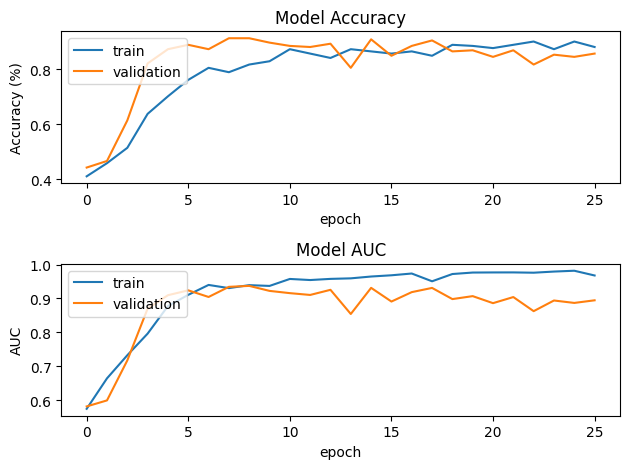

In [34]:
# plotting categorical and validation accuracy over epochs
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('Accuracy (%)')
ax1.legend(['train', 'validation'], loc='upper left')

# plotting auc and validation auc over epochs
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['auc_11'])
ax2.plot(history.history['val_auc_11'])
ax2.set_title('Model AUC')
ax2.set_xlabel('epoch')
ax2.set_ylabel('AUC')
ax2.legend(['train', 'validation'], loc='upper left')

fig.tight_layout()
plt.show()


In [35]:
# Create classification report and confusion matrix to evaluate model performance
test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predictions = model.predict(validation_iterator, steps=test_steps_per_epoch)
test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predicted_classes = numpy.argmax(predictions, axis=1)
true_classes = validation_iterator.classes
class_labels = list(validation_iterator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

cm=confusion_matrix(true_classes,predicted_classes)
print(cm)

8/8 [==============================] - 1s 68ms/step
              precision    recall  f1-score   support

       Covid       0.40      0.48      0.44       111
      Normal       0.24      0.19      0.21        70
   Pneumonia       0.28      0.26      0.27        70

    accuracy                           0.33       251
   macro avg       0.31      0.31      0.30       251
weighted avg       0.32      0.33      0.33       251

[[53 23 35]
 [46 13 11]
 [33 19 18]]
